In [ ]:
# default_exp modeling.question_answering

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.question_answering

> This module contains custom models, loss functions, custom splitters, etc... for question answering tasks

In [ ]:
#export
import ast

import torch
from transformers import *
from fastai2.text.all import *

from blurr.data.all import *
from blurr.modeling.core import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Question Answer

Given a document (context) and a question, the objective of these models is to predict the start and end token of the correct answer as it exists in the context.

In [ ]:
#export
class HF_QstAndAnsModelWrapper(HF_BaseModelWrapper):
    """A custom model wrapper for question answer models since we need all the outputs (not just the first)"""
    def forward(self, x):
        model_kwargs = {}
        model_kwargs['input_ids'] = x[0]
        if (self._include_arg('attention_mask', x[1])): model_kwargs['attention_mask'] = x[1]
        if (self._include_arg('token_type_ids', x[2])): model_kwargs['token_type_ids'] = x[2]
        if (self._include_arg('cls_index', x[3])): model_kwargs['cls_index'] = x[3]
        if (self._include_arg('p_mask', x[4])): model_kwargs['p_mask'] = x[4]
        
        return self.hf_model(**model_kwargs)

In [ ]:
#export
class HF_QstAndAnsModelCallback(HF_BaseModelCallback):  
    """We need to return everything from the model for question/answer tasks"""
    def after_pred(self): self.learn.pred = self.pred

And here we provide a custom loss function our question answer task, expanding on some techniques learned from here and here.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
#export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(self, loss_classes=[CrossEntropyLossFlat, CrossEntropyLossFlat], loss_classes_kwargs=[{}, {}], 
                 weights=[1, 1], reduction='mean'):
        
        loss_funcs = [ cls(reduction=reduction, **kwargs) for cls, kwargs in zip(loss_classes, loss_classes_kwargs) ]
        store_attr(self, 'loss_funcs, weights')
        self._reduction = reduction
        
    # custom loss function must have either a reduction attribute or a reduction argument (like all fastai and
    # PyTorch loss functions) so that the framework can change this as needed (e.g., when doing lear.get_preds 
    # it will set = 'none'). see this forum topic for more info: https://bit.ly/3br2Syz
    @property
    def reduction(self): return self._reduction
    
    @reduction.setter
    def reduction(self, v): 
        self._reduction = v
        for lf in self.loss_funcs: lf.reduction = v

    def forward(self, outputs, *targets):
        loss = 0.
        for i, loss_func, weights, output, target in zip(range(len(outputs)), 
                                                         self.loss_funcs, self.weights,
                                                         outputs, targets):
            loss += weights * loss_func(output, target) 
                
        return loss
    
    def activation(self, outs): 
        acts = [ self.loss_funcs[i].activation(o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):   
        decodes = [ self.loss_funcs[i].decodes(o) for i, o in enumerate(outs) ]
        return decodes


Again, we'll use a subset of pre-processed SQUAD v2 for our purposes below.

In [ ]:
# full
# squad_df = pd.read_csv('./data/task-question-answering/squad_cleaned.csv'); len(squad_df)

# sample
squad_df = pd.read_csv('./squad_sample.csv'); len(squad_df)

142192

In [ ]:
squad_df.head(2)

,id,title,context,question,answers,ds_type,answer_text,is_impossible
0,56be85543aeaaa14008c9063,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five G...",When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start': [269]}",train,in the late 1990s,False
1,56be85543aeaaa14008c9065,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five G...",What areas did Beyonce compete in when she was growing up?,"{'text': ['singing and dancing'], 'answer_start': [207]}",train,singing and dancing,False


In [ ]:
pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
hf_tokenizer_cls = BertTokenizer
hf_model_cls = HF_MODELS.BertForQuestionAnswering

hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,
                                                                               hf_tokenizer_cls,
                                                                               hf_model_cls)

# # here's a pre-trained roberta model for squad you can try too
# pretrained_model_name = "ahotrod/roberta_large_squad2"
# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, task=HF_TASKS_AUTO.ForQuestionAnswering)

# # here's a pre-trained xlm model for squad you can try too
# pretrained_model_name = 'xlm-mlm-ende-1024'
# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, task=HF_TASKS_AUTO.ForQuestionAnswering)

In [ ]:
squad_df = squad_df.apply(partial(pre_process_squad, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this mod

Token indices sequence length is longer than the specified maximum sequence length for this model (11 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (17 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model

Token indices sequence length is longer than the specified maximum sequence length for this model (8 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model

Token indices sequence length is longer than the specified maximum sequence length for this model (9 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (

Token indices sequence length is longer than the specified maximum sequence length for this model (17 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (23 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (22 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (17 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this mode

Token indices sequence length is longer than the specified maximum sequence length for this model (19 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (28 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (14 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (27 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this mod

Token indices sequence length is longer than the specified maximum sequence length for this model (13 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (14 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (14 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
max_seq_len= 128

In [ ]:
squad_df = squad_df[(squad_df.tokenized_input_len < max_seq_len) & (squad_df.is_impossible == False)]

In [ ]:
#hide
squad_df.head(2)

,id,title,context,question,answers,ds_type,answer_text,is_impossible,tokenized_input,tokenized_input_len,tok_answer_start,tok_answer_end
214,56be97c73aeaaa14008c912a,Beyoncé,"Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, ""to live life, to be inspired by things again"". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.",Beyonce would take a break from music in which year?,"{'text': ['2010'], 'answer_start': [60]}",train,2010,False,"[[CLS], beyonce, would, take, a, break, from, music, in, which, year, ?, [SEP], beyonce, announced, a, hiatus, from, her, music, career, in, january, 2010, ,, hee, ##ding, her, mother, ', s, advice, ,, "", to, live, life, ,, to, be, inspired, by, things, again, "", ., during, the, break, she, and, her, father, parted, ways, as, business, partners, ., beyonce, ', s, musical, break, lasted, nine, months, and, saw, her, visit, multiple, european, cities, ,, the, great, wall, of, china, ,, the, egyptian, pyramid, ##s, ,, australia, ,, english, music, festivals, and, various, museums, and, ballet...",99,23,24
215,56be97c73aeaaa14008c912b,Beyoncé,"Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, ""to live life, to be inspired by things again"". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.",Which year did Beyonce and her father part business ways?,"{'text': ['2010'], 'answer_start': [60]}",train,2010,False,"[[CLS], which, year, did, beyonce, and, her, father, part, business, ways, ?, [SEP], beyonce, announced, a, hiatus, from, her, music, career, in, january, 2010, ,, hee, ##ding, her, mother, ', s, advice, ,, "", to, live, life, ,, to, be, inspired, by, things, again, "", ., during, the, break, she, and, her, father, parted, ways, as, business, partners, ., beyonce, ', s, musical, break, lasted, nine, months, and, saw, her, visit, multiple, european, cities, ,, the, great, wall, of, china, ,, the, egyptian, pyramid, ##s, ,, australia, ,, english, music, festivals, and, various, museums, and, b...",99,23,24


In [ ]:
vocab = list(range(max_seq_len))
# vocab = dict(enumerate(range(max_seq_len)));

In [ ]:
# account for tokenizers that pad on right or left side
trunc_strat = 'only_second' if (hf_tokenizer.padding_side == 'right') else 'only_first'

hf_batch_tfm = HF_BatchTransform(hf_arch, hf_tokenizer, max_seq_len=max_seq_len, 
                                 truncation_strategy=trunc_strat, 
                                 task=ForQuestionAnsweringTask())

blocks = (
    HF_TextBlock(hf_arch, hf_tokenizer, hf_batch_tfm=hf_batch_tfm), 
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab)
)

def get_x(x):
    return (x.question, x.context) if (hf_tokenizer.padding_side == 'right') else (x.context, x.question)

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=[ColReader('tok_answer_start'), ColReader('tok_answer_end')],
                   splitter=RandomSplitter(),
                   n_inp=1)

In [ ]:
dls = dblock.dataloaders(squad_df, bs=4)

In [ ]:
len(dls.vocab), dls.vocab[0], dls.vocab[1]

(2, (#128) [0,1,2,3,4,5,6,7,8,9...], (#128) [0,1,2,3,4,5,6,7,8,9...])

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,start/end,answer
0,"what are usually universities made up of? university education includes teaching, research, and social services activities, and it includes both the undergraduate level ( sometimes referred to as tertiary education ) and the graduate ( or postgraduate ) level ( sometimes referred to as graduate school ). universities are generally composed of several colleges. in the united states, universities can be private and independent like yale university ; public and state - governed like the pennsylvania state system of higher education ; or independent but state - funded like the university of virginia. a number of career specific courses are now available to students through the internet.","(59, 61)",several colleges
1,"what is a growing sport in southern california? rugby is also a growing sport in southern california, particularly at the high school level, with increasing numbers of schools adding rugby as an official school sport.","(11, 12)",rugby


In [ ]:
model = HF_QstAndAnsModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                cbs=[HF_QstAndAnsModelCallback],
                splitter=hf_splitter)

learn.loss_func=MultiTargetLoss()
learn.create_opt()                # -> will create your layer groups based on your "splitter" function
learn.freeze()

Notice above how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

In [ ]:
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


In [ ]:
x, y_start, y_end = dls.one_batch()
preds = learn.model(x)
len(preds),preds[0].shape

(2, torch.Size([4, 128]))

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=2.2908675418875646e-06)

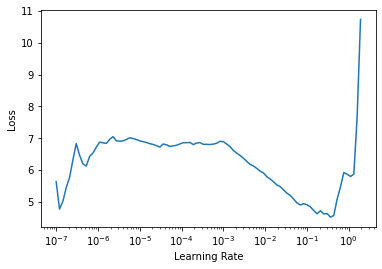

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,1.348017,1.337614,04:51
1,1.354301,1.251953,04:55
2,1.495056,1.233233,04:55


In [ ]:
#export
@typedispatch
def show_results(x:HF_QuestionAnswerInput, y, samples, outs, hf_tokenizer, skip_special_tokens=True, 
                 ctxs=None, max_n=6, **kwargs):        
    res = L()
    for inp, start, end, pred in zip(x[0], *y, outs):
        txt = hf_tokenizer.decode(inp, skip_special_tokens=skip_special_tokens).replace(hf_tokenizer.pad_token, '')
        ans_toks = hf_tokenizer.convert_ids_to_tokens(inp, skip_special_tokens=False)[start:end]
        pred_ans_toks = hf_tokenizer.convert_ids_to_tokens(inp, skip_special_tokens=False)[int(pred[0]):int(pred[1])]
        
        res.append((txt,
                       (start.item(),end.item()), hf_tokenizer.convert_tokens_to_string(ans_toks),
                       (int(pred[0]),int(pred[1])), hf_tokenizer.convert_tokens_to_string(pred_ans_toks)))

    df = pd.DataFrame(res, columns=['text', 'start/end', 'answer', 'pred start/end', 'pred answer'])
    display_df(df[:max_n])
    return ctxs

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, skip_special_tokens=True, max_n=2)

,text,start/end,answer,pred start/end,pred answer
0,"the national gallery was established in 1824 to accommodate and display what items? london is home to many museums, galleries, and other institutions, many of which are free of admission charges and are major tourist attractions as well as playing a research role. the first of these to be established was the british museum in bloomsbury, in 1753. originally containing antiquities, natural history specimens and the national library, the museum now has 7 million artefacts from around the globe. in 1824 the national gallery was founded to house the british national collection of western paintings ; this now occupies a prominent position in trafalgar square.","(101, 108)",the british national collection of western paintings,"(102, 108)",british national collection of western paintings
1,"the melbourne financial crisis was a contributing factor to what banking crisis in 1893? a brash boosterism that had typified melbourne during this time ended in the early 1890s with a severe depression of the city's economy, sending the local finance and property industries into a period of chaos during which 16 small "" land banks "" and building societies collapsed, and 133 limited companies went into liquidation. the melbourne financial crisis was a contributing factor in the australian economic depression of the 1890s and the australian banking crisis of 1893. the effects of the depression on the city were profound, with virtually no new construction until the late 1890s.","(90, 91)",australian,"(98, 101)",australian banking crisis


In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question': 'What did George Lucas make?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
}], 
    orient='columns')

learn.predict(inf_df.iloc[0])

(('11', '13'),
 tensor([11]),
 tensor([[4.0347e-05, 4.1362e-05, 5.1864e-06, 1.4169e-05, 9.1653e-06, 4.5043e-06,
          1.0833e-06, 4.0347e-05, 5.7016e-04, 6.5368e-05, 1.7340e-03, 9.9689e-01,
          5.7433e-05, 6.3186e-06, 3.7352e-05, 4.1368e-05, 6.6232e-05, 1.8288e-04,
          1.2509e-06, 5.8761e-05, 1.8421e-06, 4.0332e-05, 4.0735e-05, 4.2175e-07,
          5.5898e-07, 5.2011e-07, 4.8696e-07, 5.0784e-07, 5.6157e-07, 5.3963e-07,
          4.6394e-07, 5.2332e-07, 5.4146e-07, 5.6045e-07, 4.7320e-07, 4.1709e-07,
          4.5480e-07, 4.7657e-07, 4.1168e-07, 4.2455e-07, 4.3397e-07, 4.8114e-07,
          5.1243e-07, 4.6547e-07, 5.0378e-07, 5.3162e-07, 5.0255e-07, 4.5503e-07,
          4.9069e-07, 5.1566e-07, 5.6961e-07, 5.3764e-07, 5.3349e-07, 5.4015e-07,
          6.0204e-07, 6.1781e-07, 5.6114e-07, 5.5263e-07, 5.8322e-07, 6.6496e-07,
          6.6293e-07, 5.8047e-07, 5.3237e-07, 5.7240e-07, 6.6163e-07, 5.7301e-07,
          5.4350e-07, 5.8517e-07, 5.8506e-07, 6.4508e-07, 5.7431e-07

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question': 'When was Star Wars made?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'
}], 
    orient='columns')

test_dl = dls.test_dl(inf_df)
inp, probs, _, preds = learn.get_preds(dl=test_dl, with_input=True, with_decoded=True)

In [ ]:
hf_tokenizer.convert_ids_to_tokens(inp[0].tolist()[0], 
                                   skip_special_tokens=False)[torch.argmax(probs[0]):torch.argmax(probs[1])]

['1977']

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,time
0,1.142770,1.050102,18:19
1,1.057232,1.010325,18:20
2,1.028301,1.007020,18:20


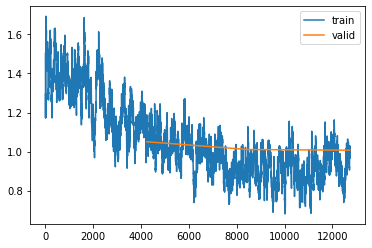

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,start/end,answer,pred start/end,pred answer
0,"the national gallery was established in 1824 to accommodate and display what items? london is home to many museums, galleries, and other institutions, many of which are free of admission charges and are major tourist attractions as well as playing a research role. the first of these to be established was the british museum in bloomsbury, in 1753. originally containing antiquities, natural history specimens and the national library, the museum now has 7 million artefacts from around the globe. in 1824 the national gallery was founded to house the british national collection of western paintings ; this now occupies a prominent position in trafalgar square.","(101, 108)",the british national collection of western paintings,"(102, 108)",british national collection of western paintings
1,"what pop singer was an original judge on american idol? american idol employs a panel of judges who critique the contestants'performances. the original judges were record producer and music manager randy jackson, pop singer and choreographer paula abdul and music executive and manager simon cowell. the judging panel for the most recent season consisted of country singer keith urban, singer and actress jennifer lopez, and jazz singer harry connick, jr. the show was originally hosted by radio personality ryan seacrest and comedian brian dunkleman, with seacrest continuing on for the rest of the seasons.","(43, 45)",paula abdul,"(43, 45)",paula abdul


In [ ]:
learn.predict(inf_df.iloc[0])

(('14', '15'),
 tensor([14]),
 tensor([[7.5529e-05, 8.2216e-05, 6.9367e-06, 9.8769e-06, 5.5935e-06, 6.5267e-05,
          3.3712e-06, 7.5539e-05, 1.2018e-04, 2.9276e-05, 9.8247e-05, 1.4854e-04,
          6.1920e-06, 4.7158e-03, 9.9446e-01, 4.0993e-06, 1.5005e-06, 1.0466e-06,
          2.1961e-07, 8.1379e-07, 1.2077e-06, 3.6372e-07, 7.5532e-05, 7.3261e-08,
          1.2024e-07, 1.0461e-07, 9.6492e-08, 8.4496e-08, 9.3348e-08, 7.3366e-08,
          7.4784e-08, 8.5400e-08, 1.1303e-07, 1.1918e-07, 8.3530e-08, 7.1964e-08,
          7.5335e-08, 7.1904e-08, 6.4147e-08, 7.2760e-08, 6.6974e-08, 7.7302e-08,
          9.1621e-08, 7.9300e-08, 7.6921e-08, 8.2644e-08, 6.5202e-08, 7.0085e-08,
          8.1191e-08, 8.0703e-08, 1.1812e-07, 1.0227e-07, 9.1381e-08, 8.9159e-08,
          9.3341e-08, 1.0252e-07, 8.4131e-08, 8.7634e-08, 9.1988e-08, 1.3078e-07,
          1.3354e-07, 9.9689e-08, 8.9235e-08, 9.1172e-08, 1.0557e-07, 8.5943e-08,
          9.0428e-08, 8.5885e-08, 9.0705e-08, 1.3724e-07, 9.2705e-08

In [ ]:
preds, pred_classes, probs = learn.predict(inf_df.iloc[0])
preds

('14', '15')

In [ ]:
inp_ids = hf_tokenizer.encode('When was Star Wars made?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[int(preds[0]):int(preds[1])]

['1977']

And what about inference?

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

In [ ]:
learn.loss_func = nn.CrossEntropyLoss()
learn.export(fname='q_and_a_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='q_and_a_learn_export.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {'question': 'Who created Star Wars?', 
     'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'}],
    orient='columns')

inf_learn.predict(inf_df.iloc[0])

(('7', '9'),
 tensor([7]),
 tensor([[2.3985e-05, 4.9380e-06, 1.6173e-06, 1.4232e-05, 2.1377e-06, 4.7048e-07,
          2.3990e-05, 9.9955e-01, 3.2451e-04, 9.1762e-07, 1.3902e-05, 5.3072e-07,
          2.4191e-06, 7.3963e-06, 4.9383e-07, 2.6963e-06, 3.9285e-07, 5.1034e-08,
          2.2397e-07, 2.1329e-07, 1.7705e-07, 2.3951e-05, 2.1348e-08, 3.5178e-08,
          2.7507e-08, 2.6653e-08, 2.6707e-08, 2.4276e-08, 2.4893e-08, 2.2572e-08,
          2.3198e-08, 4.1711e-08, 3.7398e-08, 2.4569e-08, 2.1763e-08, 2.3147e-08,
          2.1358e-08, 1.9942e-08, 2.3819e-08, 2.3629e-08, 2.4614e-08, 2.6290e-08,
          2.7115e-08, 2.4891e-08, 2.5402e-08, 2.5248e-08, 2.2568e-08, 2.7994e-08,
          3.1155e-08, 3.7380e-08, 4.1601e-08, 3.5434e-08, 3.0658e-08, 2.8340e-08,
          2.9366e-08, 2.9983e-08, 2.8146e-08, 2.8612e-08, 4.4128e-08, 4.3962e-08,
          3.0979e-08, 2.7612e-08, 2.8154e-08, 2.8107e-08, 3.0106e-08, 2.6725e-08,
          2.9694e-08, 2.8886e-08, 3.7722e-08, 3.5493e-08, 2.7634e-08, 2

In [ ]:
inp_ids = hf_tokenizer.encode('Who created Star Wars?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[7:9]

['george', 'lucas']

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-language-modeling.ipynb.
Converted 01c_data-question-answering.ipynb.
Converted 01d_data-token-classification.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-language-modeling.ipynb.
Converted 02c_modeling-question-answering.ipynb.
Converted 02d_modeling-token-classification.ipynb.
Converted index.ipynb.
